In [25]:
# vocab
# simple encoding word index

text_corpus = "How are you doing ? I am good and you ?"
vocab = sorted(list(set(text_corpus.lower().split(" "))))
SOS_token = 0
EOS_token = 1
index2words = {SOS_token: "SOS", EOS_token: "EOS"}
for i, word in enumerate(vocab):
    index2words[i + 2] = word
words2index = {w: i for i, w in index2words.items()}
print("words2index", words2index)
print("index2words", index2words)

words2index {'SOS': 0, 'EOS': 1, '?': 2, 'am': 3, 'and': 4, 'are': 5, 'doing': 6, 'good': 7, 'how': 8, 'i': 9, 'you': 10}
index2words {0: 'SOS', 1: 'EOS', 2: '?', 3: 'am', 4: 'and', 5: 'are', 6: 'doing', 7: 'good', 8: 'how', 9: 'i', 10: 'you'}


In [26]:
import torch


def sent2tensor(sent: str):
    idxs = []
    for word in sent.lower().split(" "):
        idxs.append(words2index[word])
    return torch.tensor(idxs, dtype=torch.long).view(1, -1)


sent2tensor("How are you ?")

tensor([[ 8,  5, 10,  2]])

In [27]:
# encoder
import torch.nn as nn


class RnnEncoder(nn.Module):
    def __init__(self, input_size, gru_size) -> None:
        super().__init__()
        self.embed_layer = nn.Embedding(
            num_embeddings=input_size, embedding_dim=gru_size
        )  # embeddings are low-dimensional, learned continuous vector representations of discrete variables. they can reduce the dimensionality of categorical variables and meaningfully represent categories in the transformed space
        self.gru_layer = nn.GRU(gru_size, gru_size, batch_first=True, num_layers=1)

    def forward(self, word_tensor):
        emb_vector = self.embed_layer(word_tensor)
        output, hidden = self.gru_layer(emb_vector)
        return output, hidden


encoder = RnnEncoder(input_size=len(words2index), gru_size=3)

sentence = "How are"
input_tensor = sent2tensor(sentence)
print("gru in \n", input_tensor)
output, hidden = encoder(input_tensor)
print("gru out \n", output)
print("gru hidden \n", hidden)

gru in 
 tensor([[8, 5]])
gru out 
 tensor([[[ 0.1210,  0.0073,  0.1010],
         [ 0.0538, -0.1893,  0.0966]]], grad_fn=<TransposeBackward1>)
gru hidden 
 tensor([[[ 0.0538, -0.1893,  0.0966]]], grad_fn=<StackBackward0>)


In [28]:
import torch.nn.functional as F

MAX_LENGTH = 2


class RnnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(RnnDecoder, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for _ in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(
                decoder_input, decoder_hidden
            )
            decoder_outputs.append(decoder_output)

            _, topIdx = decoder_output.topk(1)
            decoder_input = topIdx.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden

    def forward_step(self, input_tensor, hidden):
        output = self.embedding(input_tensor)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [29]:
def tensor2sent(tensor):
    words_list = [index2words[idx.item()] for idx in tensor]
    return " ".join(words_list)

In [30]:
encoder = RnnEncoder(input_size=len(words2index), gru_size=3)
decoder = RnnDecoder(hidden_size=3, output_size=len(words2index))

sentence = "How are"
input_tensor = sent2tensor(sentence)
output, hidden = encoder(input_tensor)
decoder_outputs, decoder_hidden = decoder(output, hidden)
_, topIdx = decoder_outputs.topk(1)
decoded_ids = topIdx.squeeze()
tensor2sent(decoded_ids)

'SOS SOS'

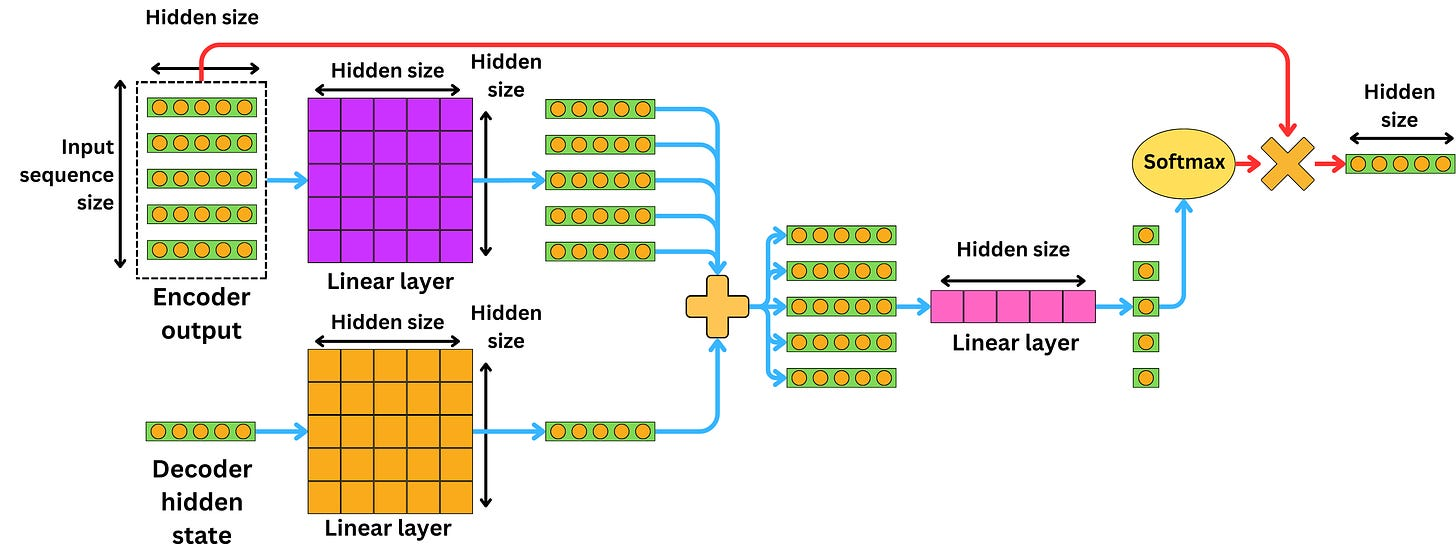

In [31]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, hidden, encoder_output):
        scores = torch.tanh(self.W(hidden) + self.U(encoder_output))
        scores = self.V(scores)
        scores = scores.squeeze(2).unsqueeze(1)

        attention = F.softmax(scores, dim=-1)
        context = torch.bmm(attention, encoder_output)

        return context, attention

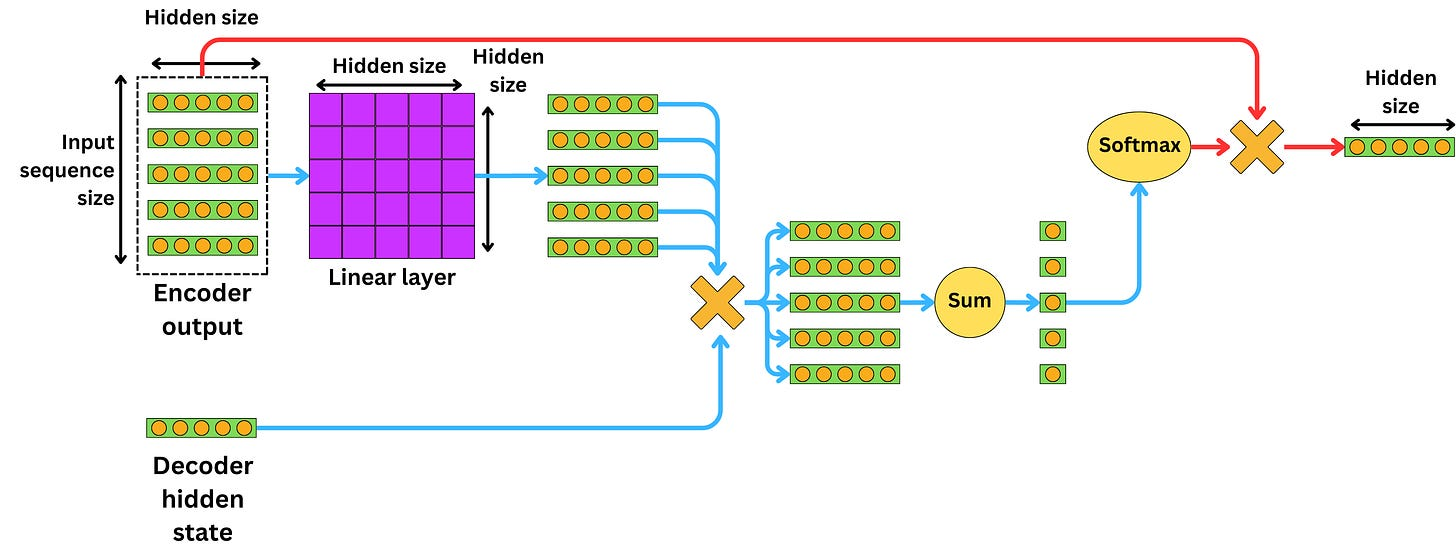

In [32]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.W = nn.Linear(hidden_size, hidden_size)

    def forward(self, hidden, encoder_output):
        scores = self.W(encoder_output)
        scores = torch.sum(hidden * scores, dim=2)

        attention = F.softmax(scores, dim=-1)
        attention = attention.unsqueeze(1)
        context = torch.bmm(attention, encoder_output)

        return context, attention

In [33]:
MAX_LENGTH = 10


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward_step(self, decoder_input, hidden, encoder_outputs):
        embedded = self.embedding(decoder_input)

        context, _ = self.attention(hidden, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden

    def forward(self, encoder_outputs, encoder_hidden):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)

            _, topIdx = decoder_output.topk(1)
            decoder_input = topIdx.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

        return decoder_outputs, decoder_hidden

In [35]:
decoder = AttnDecoderRNN(
    hidden_size=3, 
    output_size=len(words2index)
)

sentence = "How are you doing ?"
input_tensor = sent2tensor(sentence)
output, hidden = encoder(input_tensor)
decoder_outputs, decoder_hidden = decoder(output, hidden)

def convert2sentence(tensor):
    words_list = [index2words[idx.item()] for idx in tensor]
    return ' '.join(words_list)

_, topIdx = decoder_outputs.topk(1)
decoded_ids = topIdx.squeeze()

convert2sentence(decoded_ids)

'you you you you you you you you you you'